# Pytorch



Pytorch - очень мощный инструмент разработки в области нейронных сетей и глубинного обучения. Этот фреймворк совмещает в себе ряд важных инструментов и методов, которые можно применять для конструирования практически любой архитектуры на основе известных блоков, эффективно работать с данными и проводить вычисления на gpu, производить автоматическое дифференцирование и обновление весов моделей при помощи различных оптимизаторов. У Pytorch отличная документация, позволяющая разобраться самостоятельно даже в довольно сложных структурах. Сегодня мы обсудим этот фреймворк и научимся использовать его для построения и обучения нейронных сетей.




## torch.Tensor

Базовой структурой фреймворка является структура, которая называется `torch.Tensor`. Tensor - это аналог `numpy.array`, многие методы работы с `torch.Tensor` в точности повторяют методы `numpy array`.

Импортируем библиотеку и рассмотрим типичные способы создания тензоров.

In [1]:
import torch
import warnings
warnings.filterwarnings('ignore')

1. Тензоры можно создавать из листов, массивов и других контейнеров.

In [10]:
list2tensor = [1., 2., 3.]
tensor = torch.tensor(list2tensor)
tensor

tensor([1., 2., 3.])

In [11]:
type(tensor)

torch.Tensor

2. Тензоры можно создавать при помощи инициализирующих функций, как в `numpy`.

In [29]:
zeros_tensor = torch.zeros(2, 3)
zeros_tensor

tensor([[0., 0., 0.],
        [0., 0., 0.]])

In [13]:
ones_tensor = torch.ones(2, 3)
ones_tensor

tensor([[1., 1., 1.],
        [1., 1., 1.]])

In [14]:
eye_tensor = torch.eye(6)
eye_tensor

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]])

## Автоматическое дифференцирование

Тензор - это структура данных, которая может быть встроена в качестве переменной в любой **вычислительный граф** и хранить информацию не только о текущем значении этой переменной, но и о **градиенте** вычисляемой функции по текущей переменной.

Поясню эту мысль на конкретном примере.
Пусть мы хотим вычислить функцию от двух переменных $$u(x, y) = 2x^2 + 3y^2 - x - y$$

Вычисление этой функции можно задать в виде **графа**, каждая вершина которого отвечает некоторой элементарной операции.

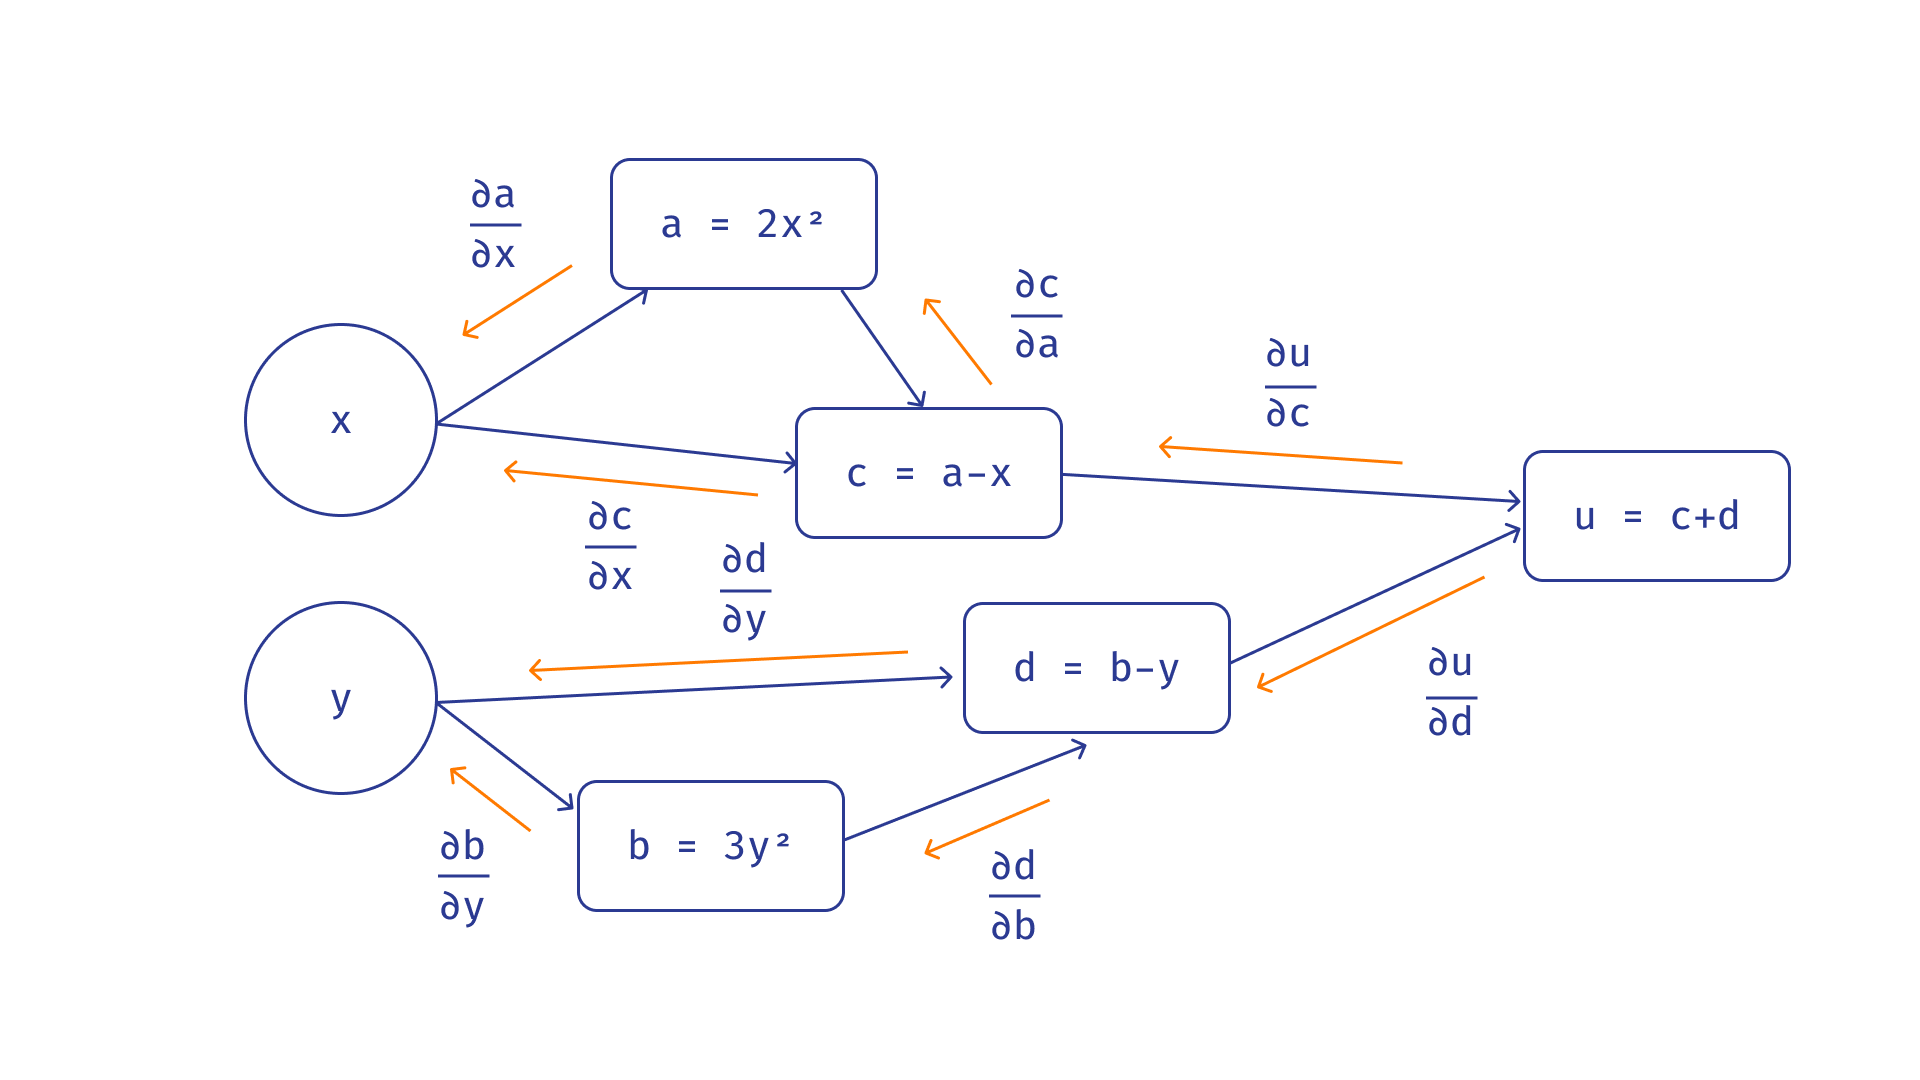

По каждой из переменных, участвующих в итоговом вычислении функции $u$, мы можем посчитать частную производную. Причем для вычисления частных производных для более "отдалённых" переменных мы можем воспользоваться известным правилом дифференцирования сложной функции:
$$\frac{∂ y(Φ(x))}{\partial x} = \frac{∂ y(Φ(x))}{\partial Φ(x)}⋅\frac{∂Φ(x)}{\partial x}$$

В нашем случае это значит, что
$$\frac{∂u}{∂x} = \frac{∂ u}{∂ c}(\frac{∂c}{∂a}\frac{∂a}{∂x} + \frac{∂c}{∂x})$$
$$\frac{∂u}{∂y} = \frac{∂ u}{∂ d}(\frac{∂d}{∂b}\frac{∂b}{∂y} + \frac{∂d}{∂y})$$

Каждую из этих частных производных мы можем вычислить, причём обратите внимание на следующую деталь: **частные производные более низкого уровня выражаются через частные производные более высокого**. Мы воспользуемся очень похожей идеей немного позже.

В тензоре `pytorch.tensor` есть специальное поле, позволяющее хранить значения частных производных его элементов. Это поле называется `.grad`. Нужно отметить, что это поле имеется только у тех тензоров, у которых было установлено соответствующее значение флага `requires_grad=True` при инициализации.

In [16]:
x = torch.tensor([1.], requires_grad=True)
y = torch.tensor([2.], requires_grad=True)

a = 2*torch.pow(x, 2)
b = 3*torch.pow(y, 2)

c = a - x
d = b - y

u = c + d


При заданных нами значениях $x$ и $y$ мы должны были получить следующий результат:

$$a = 2*1^2 = 2$$
$$b = 3*2^2 = 12$$
$$c = 2 - 1 = 1$$
$$d = 12 - 3 = 9$$
$$u = 1 + 9 = 10$$

In [17]:
u

tensor([11.], grad_fn=<AddBackward0>)

In [18]:
a

tensor([2.], grad_fn=<MulBackward0>)

In [19]:
b

tensor([12.], grad_fn=<MulBackward0>)

In [20]:
c

tensor([1.], grad_fn=<SubBackward0>)

In [21]:
d

tensor([10.], grad_fn=<SubBackward0>)

**Замечание 1:** На практике довольно часто возникают ситуации, когда мы работаем с тензором, содержащим всего одно значение. Например, когда мы посчитали значение функции потерь на некотором наборе данных и хотим помимо всего прочего вывести это значение на экран или передать его в логгер. В таком случае мы бы хотели получить это значение в виде вещественного числа, а не тензора. Конечно, возможен вариант обращения к этому значению по индексу, но существует намного более удобный и элегантный способ обратиться к этому значению - использование функции `.item()`

In [22]:
u

tensor([11.], grad_fn=<AddBackward0>)

In [27]:
u[0]

tensor(11., grad_fn=<SelectBackward0>)

In [12]:
u.item()

11.0

**Замечанние 2:** Обратите внимание, что при выводе на экран каждого из тензоров, с которыми мы работаем, мы видим не только набор данных, содержащихся в этом тензоре, но и значение `grad_fn`. `grad_fn` - это аттрибут, хранящий информацию о том, какая функция будет использована для вычисления градиента по данной переменной. Например, если речь идёт о переменной `c`, полученной при помощи операции вычитания, градиент будет посчитан при помощи `SubBackward` (от англ. *Substruction* - вычитание).

### Вычисление градиентов

Вычислить градиенты по каждой из переменных, участвовавших в вычислении итоговой функции в `pytorch` очень просто. Для этого достаточно вызвать метод `.backward()`. После этого произойдёт следующее: для каждой из переменных, от которых итоговая функция зависит непосредственно (назовём их переменными первого уровня), будут посчитаны значения производных при помощи записанных `grad_fn`, затем эта операция будет повторена для всех переменных от которых зависят переменные первого уровня и т.д.

То есть, как только мы выполним операцию `u.backward()`, произойдут следующие вычисления: будут посчитаны частные производные $\frac{\partial u}{\partial c}$ и $\frac{\partial u}{\partial d}$, затем $\frac{\partial u}{\partial a} = \frac{\partial u}{\partial c}\frac{\partial c}{\partial a}$ и т.д. и каждая из этих производных будет записана в поле `.grad` соответсвующего тензора.

**Замечание:** на самом деле непосредственно обратиться можно только к градиентам листовых переменных графа вычислений (то есть тех, которые подаются сами по себе, а не на основе вычисления некоторых промежуточных значений, в нашем случае это $x$ и $y$). Для обращения к остальным частным производным нужно провести некоторую дополнительную операцию, о которой мы не будем подробно говорить в силу того, что её на практике обычно не применяют.

In [30]:
u.backward()

Теперь мы можем обратиться к значения производных $\frac{\partial u}{\partial x}$ и $\frac{\partial u}{\partial y}$

In [31]:
x.grad

tensor([3.])

In [32]:
y.grad

tensor([11.])

## Нейронные сети на Pytorch

Теперь мы переходим к самому интересному - созданию полноценных нейронных сетей на основе модулей Pytorch. Нейронные сети в Pytorch похожи на конструктор: есть набор стандартных блоков из которых мы можем собрать итоговую модель. На прошлой лекции мы разбирали структуру полносвязных нейронных сетей, а также обсуждали что такое слой полносвязной нейронной сети. Построим свою собственную полносвязную нейронную сеть на основе готовых блоков Pytorch.

Каждый полносвязный слой представляет из себя комбинацию линейного преобразования $W \cdot X + B$ и некоторого нелинейного заданного заранее выбранной **функцией активации**.

Слой, представляющий из себя линейное преобразование задаётся при помощи класса `torch.nn.Linear`. Модуль `torch.nn` вообще активно применяется при работе с нейронными сетями в `pytorch`.

Для создания линейного слоя с матрицей, инициализированной случайными параметрами, размера $n \times m$ мы воспользуемся следующей командой:

In [37]:
import torch.nn as nn

n = 5
m = 3
linear_layer = nn.Linear(n, m)
type(linear_layer)

torch.nn.modules.linear.Linear

$n$ в данном случае - размерность признакового описания данных, с которыми мы будем работать, а $m$ - это число нйеронов в слое.

Далее зададим функцию активации. Многие известные функции активации реализованы в модуле `nn` и продублированы в модуле `nn.functional`. Выберем какую-нибудь из них, например, гиперболический тангенс (tanh).

In [36]:
import torch.nn.functional as F

# Можно использовать такой вариант
# activation = F.tanh
# или более правильный вариант:
activation = nn.Tanh()
type(activation)

torch.nn.modules.activation.Tanh

**Замечание:** второй вариант является более правильным, поскольку при использовании функций активации из `torch.nn` мы получаем готовые объекты, имеющие интерфейс слоя, что убережёт нас от неожиданных ошибок. Использование же функций напрямую из `torch.nn.functional` иногда может приводить к не вполне корректной работе сложных моделей. Безопаснее и правильнее использовать именно классы из `torch.nn`, однако очень часто на раличных ресурсах, посвященных  `Pytorch`, можно встретить использование объектов из `torch.nn.functional`, поэтому мы считаем нужным рассказать и о таком способе использования функций активации.

Теперь проход некоторого тензора с данными через такой полносвязный слой будет задан при помощи последовательности команд:

In [41]:
random_input = torch.rand(n)

z = linear_layer(random_input)
output = activation(z)
output

tensor([-0.5175, -0.3373,  0.1201], grad_fn=<TanhBackward0>)

Самый простой способ объединить несколько модулей в цепочку последовательных вычислений - это использование модуля `nn.Sequential`. Этот класс позволит нам объединить несколько модулей в один контейнер так, что в случае применения этого контейнера к некоторму тензору, вычисления будут проведены в том порядке, в котором мы передали элементы. То есть предыдущую ячейку можно заменить на следующий фрагмент кода:

In [50]:
FF_layer = nn.Sequential(linear_layer, activation)
FF_layer(random_input)

tensor([-0.5175, -0.3373,  0.1201], grad_fn=<TanhBackward0>)

Мы получили точно такой же результат. Давайте применим этот инструмент для решения какой-нибудь простой задачи. Например, попробуем смоделировать функцию косинуса при помощи полносвязной нейронной сети.

### Пример: приближение функции косинуса

Прежде всего зададим одномерный датасет.

In [51]:
X = torch.normal(mean=torch.zeros((1000, 1)), std= 2)
Y = torch.cos(X)

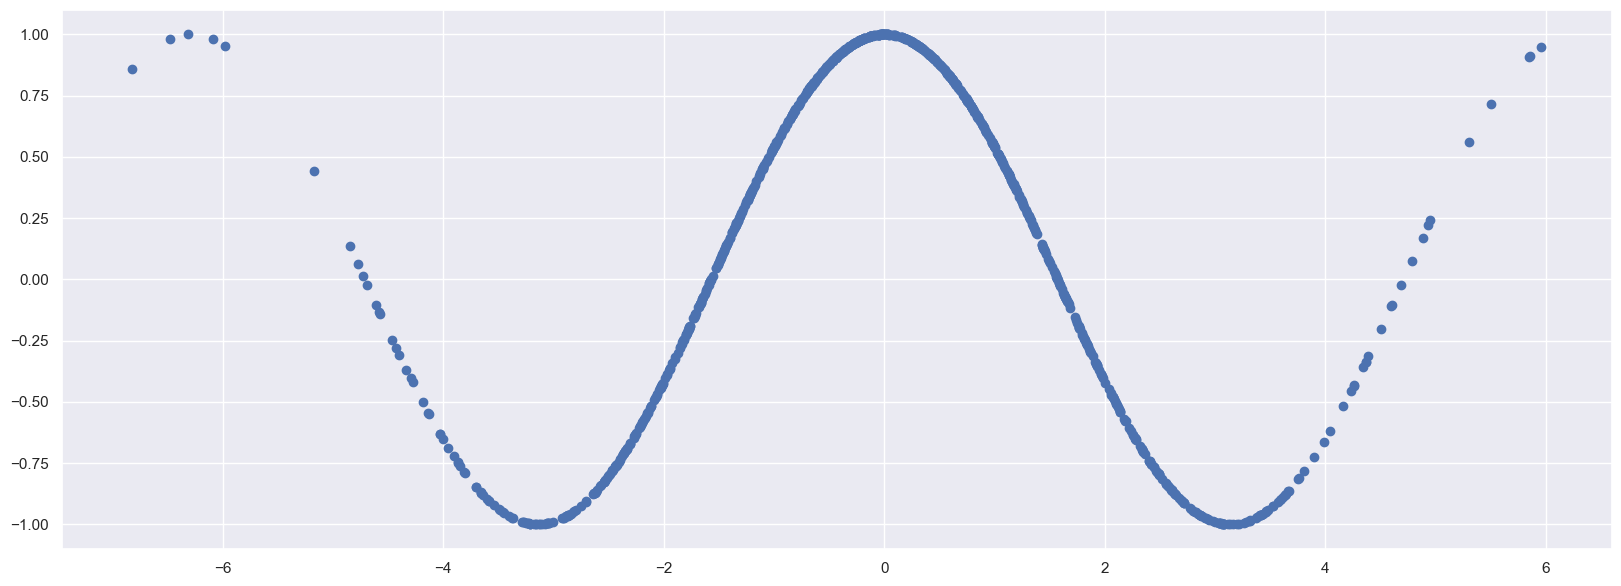

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

plt.figure(figsize=(20,7))
plt.scatter(x=X, y=Y);

Теперь зададим нейронную сеть. Перед нами встаёт непростой выбор архитектуры нейронной сети. Мы должны подобрать такое количество нейронов, чтобы нейронная сеть не переобучилась, но при этом была достаточно ёмкой чтобы выучить неизвестную зависимость. К счастью, в таком простом случае вопрос о переобучении модели вообще не стоит. Попробуем выбрать трёхслойную нейронную сеть, в каждом слое которой будет по 5 нейронов, а в последнем - только один. В качестве функции активации выберем гиперболический тангенс.

In [56]:
import torch.nn as nn
NN = nn.Sequential(nn.Linear(1, 5, bias=True),
                   nn.Tanh(),
                   nn.Linear(5, 5, bias=True),
                   nn.Tanh(),
                   nn.Linear(5, 1, bias=True),
                   nn.Tanh())

Посмотрим, что умеет наша нейронная сеть прямо сейчас

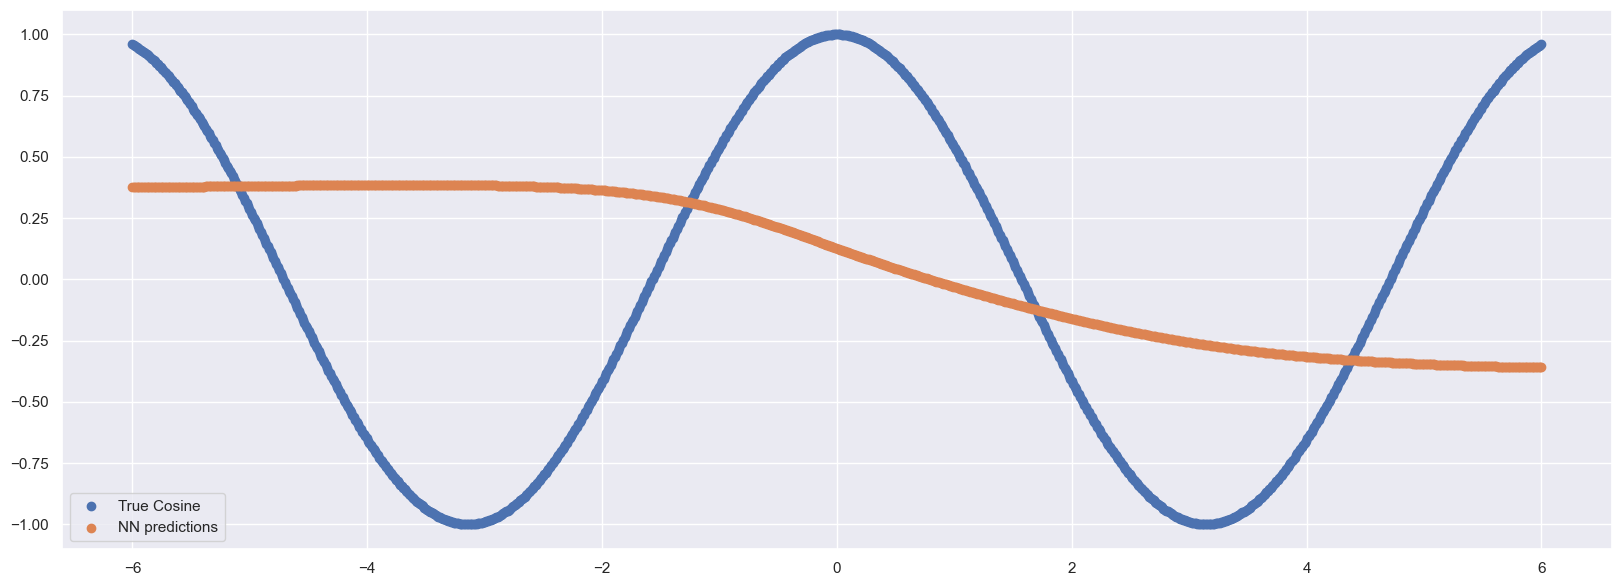

In [ ]:
X_test = torch.linspace(-6, 6, 1000)
Y_test = torch.cos(X_test)

nn_prediction = NN(X_test.view(-1, 1))
nn_prediction = nn_prediction.detach().numpy()

plt.figure(figsize=(20,7))
plt.scatter(x=X_test, y=Y_test, label='True Cosine');
plt.scatter(x=X_test, y=nn_prediction, label='NN predictions');
plt.legend()

**Замечание 1:** в 4 строке предыдущей ячейки мы воспользовались функцией `.view()`. `.view()` - это альтернатива функции `.reshape()`, позволяющая изменить размерность тензора без изменения данных в нём. Здесь мы применили её для того, чтобы сделать из вектора входных данных матрицу того же размера. Эта формальность необходима для корректного прохода тензора через наши преобразования.

**Замечание 2:** в 5 строке мы выполнили комбинацию методов тензора `.detach().numpy()`. Функция `.detach()` нужна для извлечения тензора из графа вычислений, а функция `.numpy()` для получения массива `numpy` из тензора. В целом это необходимо нам для визуализации результата

Полученный результат ожидаем, поскольку наша нейронная сеть не обучена. Давайте обучим её. Но сначала поговорим о том, как вообще это можно сделать.


## Обучение нейронных сетей

Нейронные сети обучаются при помощи градиентных алгоритмов оптимизации. Градиентные алгоритмы - это алгоритмы, основанные на базовой идее алгоритма градиентного спуска: последовательном вычислении приближений оптимальных параметров нейронной сети на основе вычисления градиентов по этим параметров и выполнения шага градиентного спуска:

$$W_{t+1} = W_t - λ\cdot∇L_W$$

На основе стандартного градиентного спуска было придумано большое количество модификаций. Наиболее популярной и эффективной модификацией на сегодняшний день является алгоритм **ADAM** (Adaptive Gradients with Momentum). Для каждого из возможных градиентных методов встаёт вопрос об эффективном способе вычисления градиента функции потерь по параметрам глубокой нейронной сети. Для этой цели существует известный алгоритм **обратного распространения ошибки** (backpropagation).

## Обучение нейронной сети в Pytorch

На самом деле алгоритм bacpropagation уже заложен в pytorch как элемент стандартных оптимизаторов, так что нам не придётся думать о его численной реализации.

Напишем свою функцию `train` для обучения нейронной сети.

Эта функция примет следующие аргументы:

- model - нейронная сеть
- x и y - обучающая выборка
- criterion - функция потерь, взятая из модуля `torch.nn`
- optimizer - оптимизатор, взятый из модуля `torch.optim`
- num_epoch - количество эпох обучения, то есть число градиентных шагов, которые будут выполнены для каждого объекта в выборке

In [72]:
import tqdm
from tqdm.auto import tqdm
def train(model, x, y, criterion, optimizer, num_epoch):
    for t in tqdm(range(num_epoch)):
      # Внещний цикл по числу эпох обучения
        for i, X in enumerate(x):
            # Внутренний цикл по всем объектам в обучающей выборке
            # Вычислим предсказания нашей модели
            y_pred = model(X)

            # Посчитаем значение функции потерь  на полученном предсказании
            loss = criterion(y_pred, y[i])

            # Обнулим посчитанные ранее значения градиентов
            optimizer.zero_grad()

            # Выполним подсчёт новых градиентов
            loss.backward()

            # Выполним шаг градиентного спуска
            optimizer.step()
    return model

Обучим нашу нейронную сеть, выбрав в качестве функции потерь среднеквадратичную ошибку, реализованную в `nn.MSELoss`, а в качестве оптимизатора - **ADAM**. В аргументы оптимизатора мы дожны передать параметры нашей модели, а также значение множителя перед градиентом в шаге градиентного спуска *learning rate*

In [73]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(NN.parameters(), lr=1e-2)

NN = train(NN, X, Y, criterion,optimizer, 5)

100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Посмотрим теперь, каков будет результат.

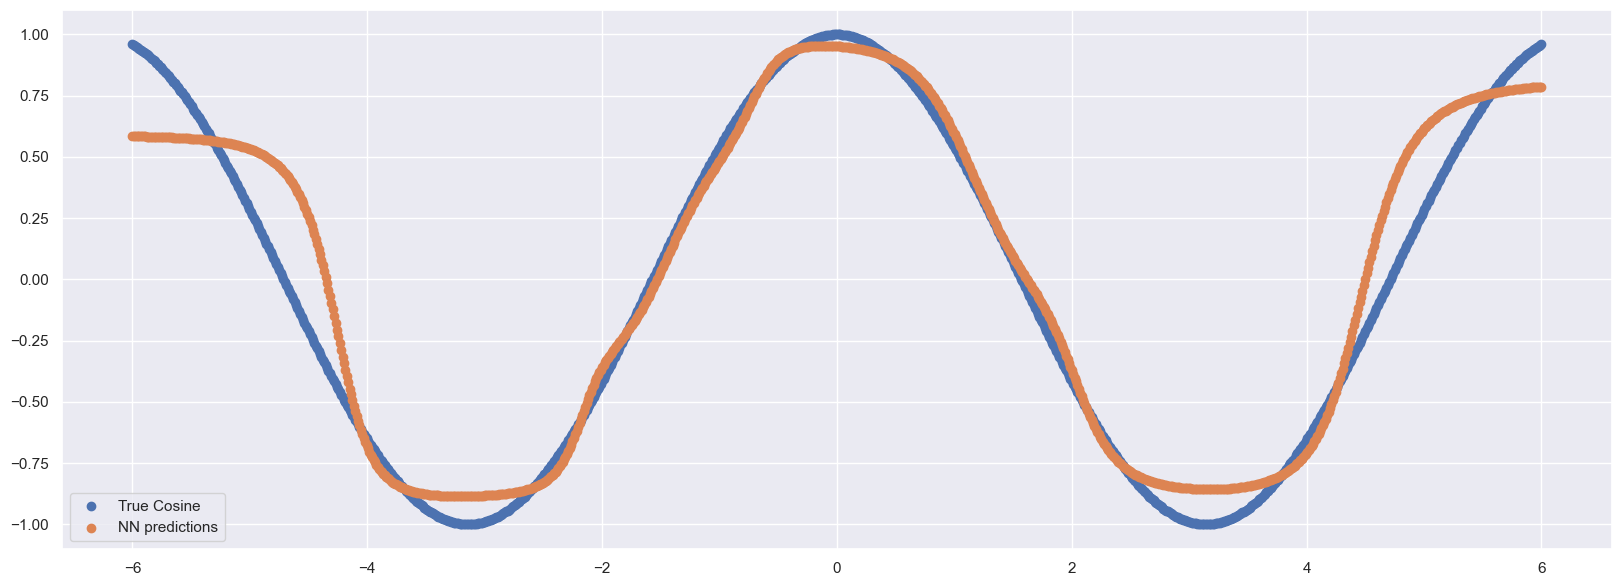

In [74]:
nn_prediction = NN(X_test.view(-1, 1))
nn_prediction = nn_prediction.detach().numpy()

plt.figure(figsize=(20,7))
plt.scatter(x=X_test, y=Y_test, label='True Cosine');
plt.scatter(x=X_test, y=nn_prediction, label='NN predictions');
plt.legend()

Стало заметно лучше, но явно требуется еще несколько итераций обучения.

In [75]:
NN = train(NN, X, Y, criterion, optimizer, 15)

100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


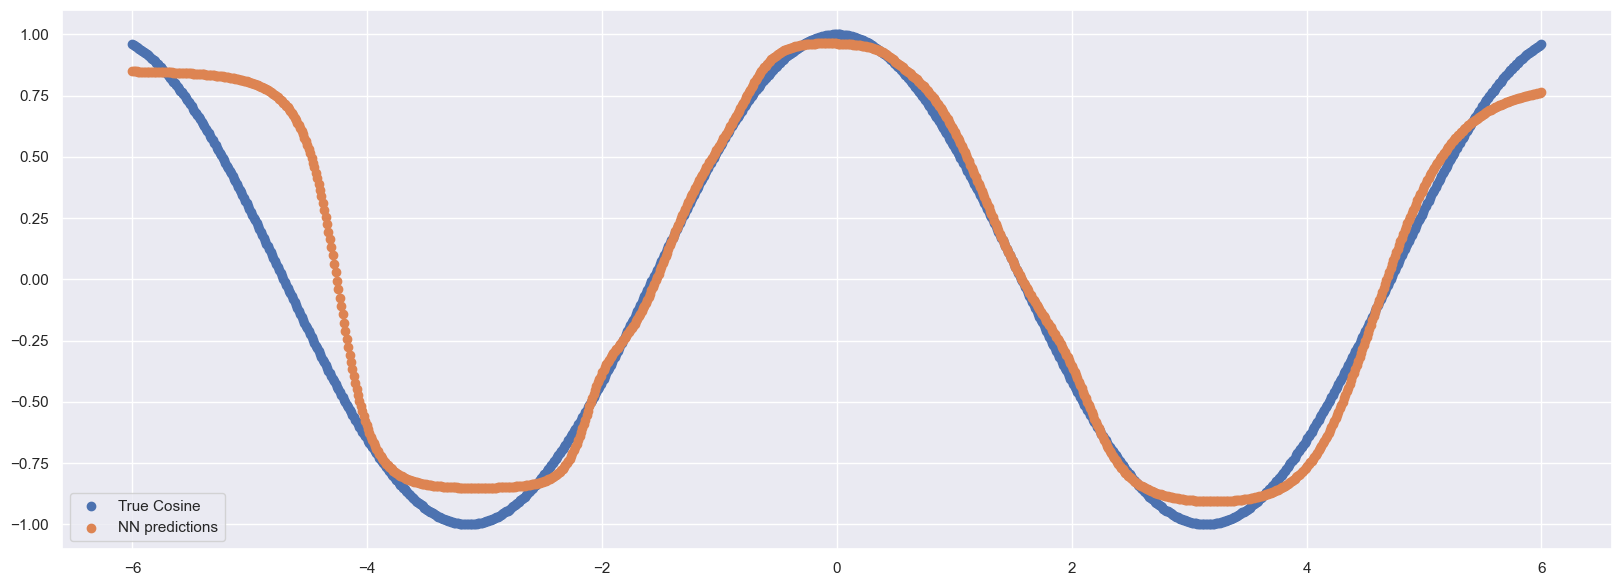

In [76]:
nn_prediction = NN(X_test.view(-1, 1))
nn_prediction = nn_prediction.detach().numpy()

plt.figure(figsize=(20,7))
plt.scatter(x=X_test, y=Y_test, label='True Cosine');
plt.scatter(x=X_test, y=nn_prediction, label='NN predictions');
plt.legend()

Один из возможных вариантов улучшения сходимости - это уменьшение градиентного шага. Давайте понизим его до 0.001 и выполним еще несколько итераций обучения.

In [77]:
optimizer = torch.optim.Adam(NN.parameters(), lr=1e-3)

NN = train(NN, X, Y, criterion,optimizer, 25)

100%|██████████| 25/25 [00:47<00:00,  1.92s/it]


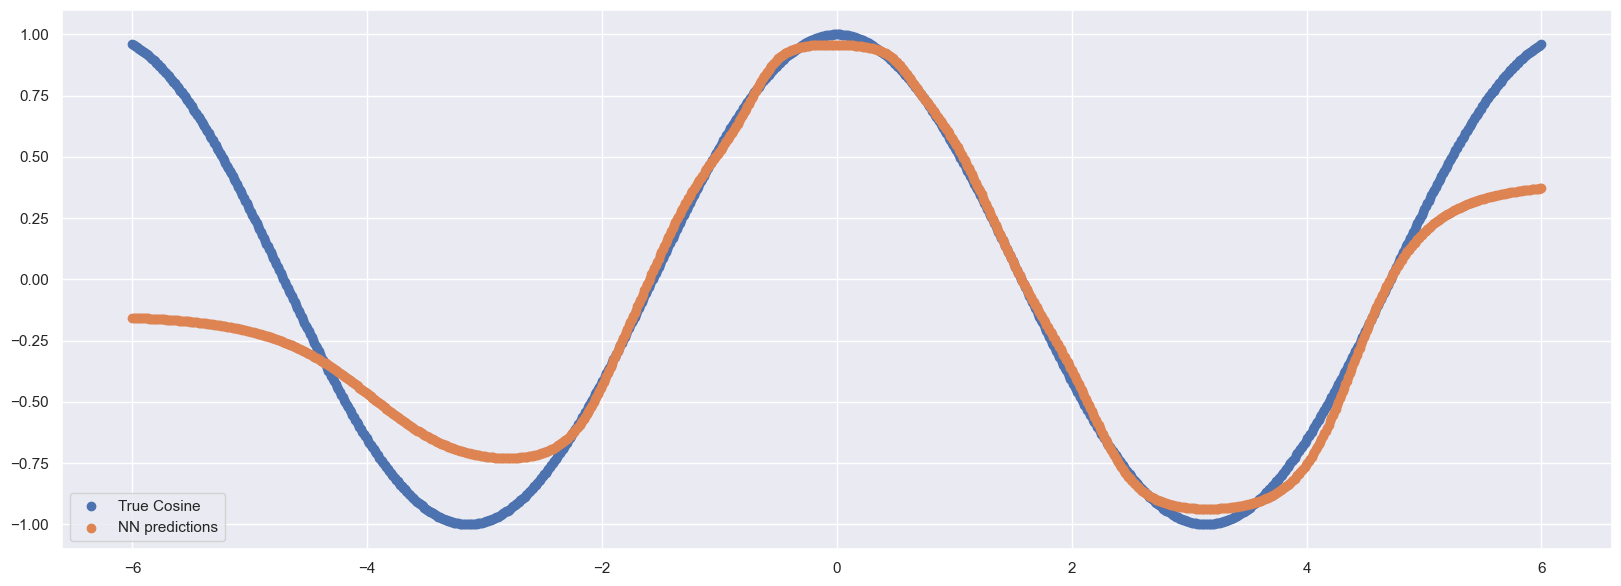

In [65]:
nn_prediction = NN(X_test.view(-1, 1))
nn_prediction = nn_prediction.detach().numpy()

plt.figure(figsize=(20,7))
plt.scatter(x=X_test, y=Y_test, label='True Cosine');
plt.scatter(x=X_test, y=nn_prediction, label='NN predictions');
plt.legend()

Результат стал существенно лучше.

Мы видим несовершенство аппроксимации на краях графика, это связано прежде всего с тем, что в нашей исходной выборке координаты взяты из нормального распределения, поэтому объектов, лежащих за пределами границ -3 и +3 очень мало, а значит мало прецедентов, по которым обучается наша нейронная сеть.

## Наследование от класса nn.Module

Иногда такой простой структуры как `Sequential` недостаточно для создания достаточно сложных моделей. Иногда это связано с тем, что в вычислениях нужно создать несколько независимых веток. Могут быть и другие причины. В любом случае хотелось бы иметь возможность вмешиваться в результаты промежуточных вычислений. Для этого существует более гибкий способ работать с нейронными сетями в Pytorch - это написание собственных классов, унаследованных от класса `nn.Module`.

Описание прямого прохода через такой блок происходит в форме спецификации функции `forward`.

In [78]:
class Net(nn.Module):
    def __init__(self, dim):
      #dim - размерность, self - функция активации
        super(Net, self).__init__()
        self.L1 = nn.Linear(dim, 5)
        self.L2 = nn.Linear(5, 5)
        self.L3 = nn.Linear(5, 1)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.L1(x)
        x = self.activation(x)
        x = self.L2(x)
        x = self.activation(x)
        x = self.L3(x)
        return self.activation(x)

In [79]:
NN = Net(1)

Обучить такую модель можно точно также - при помощи уже имеющейся у нас функции `train`

In [80]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(NN.parameters(), lr=1e-3)

NN = train(NN, X, Y, criterion,optimizer, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:35<00:00,  1.56s/it]


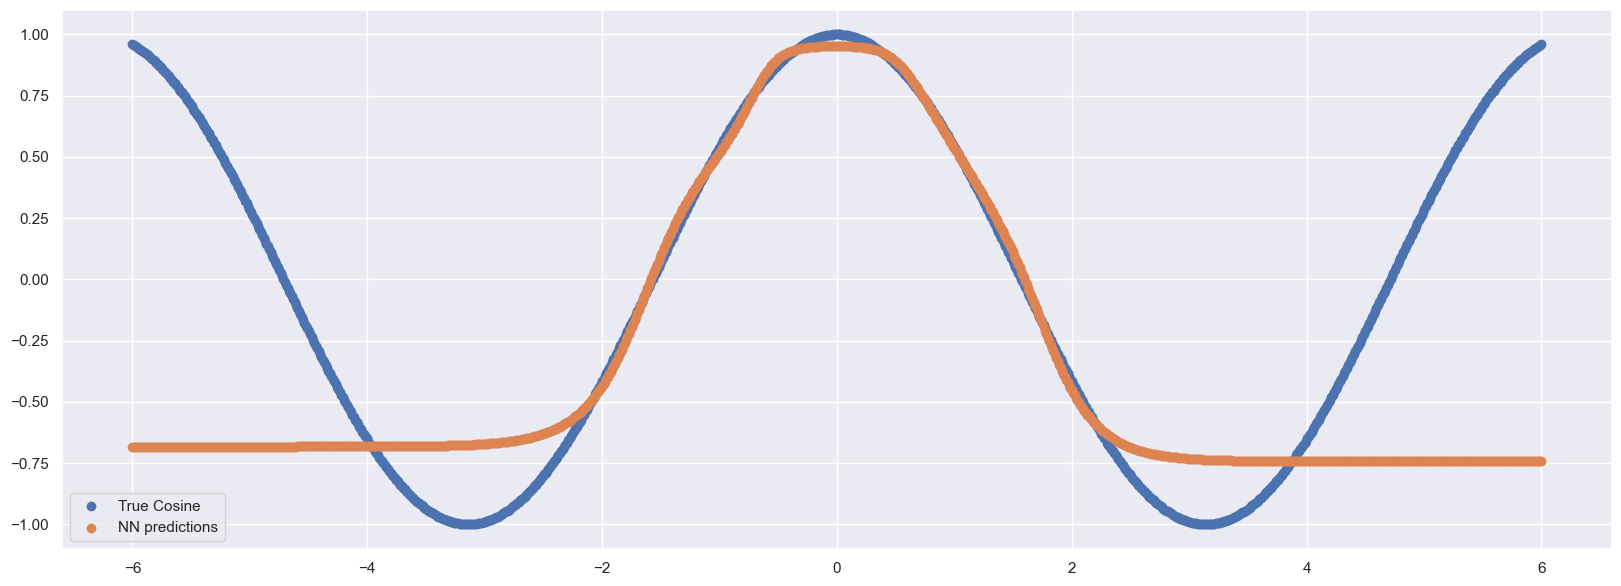

In [81]:
nn_prediction = NN(X_test.view(-1, 1))
nn_prediction = nn_prediction.detach().numpy()

plt.figure(figsize=(20,7))
plt.scatter(x=X_test, y=Y_test, label='True Cosine');
plt.scatter(x=X_test, y=nn_prediction, label='NN predictions');
plt.legend()

Наследование от класса `nn.Module` позволяет реализовать совместимость нашей модели с интерфейсом `Pytorch`, а также использовать некоторые дополнительные возможности. К примеру, мы можем получить доступ к параметрам модели в матричном виде:

In [101]:
for param in NN.parameters():
  print('parameter shape: ', param.shape)

for name, p in NN.named_parameters():
    print(name, p.shape)

parameter shape:  torch.Size([5, 1])
parameter shape:  torch.Size([5])
parameter shape:  torch.Size([5, 5])
parameter shape:  torch.Size([5])
parameter shape:  torch.Size([1, 5])
parameter shape:  torch.Size([1])
L1.weight torch.Size([5, 1])
L1.bias torch.Size([5])
L2.weight torch.Size([5, 5])
L2.bias torch.Size([5])
L3.weight torch.Size([1, 5])
L3.bias torch.Size([1])


## Перенос вычислений на видеокарту

Использование графических ядер - обязательный атрибут работы с глубокими нейронными сетями. Графические ядра позволяют производить быстрые эффективные параллельные вычисления. В `Pytorch` реализован интерфейс переноса вычислений на видеокарту. Для осуществления этого переноса необходимо перенестина видеокарту как параметры модели, так и входные данные. Прежде всего нужно проверить, доступна ли видеокарта для вычислений. В google-colab для этого нужно в главном меню выбрать вкладку "Среда выполнения", там выбрать команду "Сменить среду выполнения", далее в качестве аппаратного ускорителя выбрать "GPU". После этого можно воспользоваться следующей командой для проверки доступности GPU:

In [83]:
import torch
torch.cuda.is_available()

False

In [84]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Теперь можем провести вычисления на GPU. Перенос тензоров и модулей на GPU производится при помощи функций `.to('gpu')`, либо `.cuda()`

**Замечание:** мы вынуждены продублировать определения основных функций, поскольку после подключения аппаратного ускорителя среда выполнения перезагружается

In [85]:
import torch.nn as nn
class Net(nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()
        self.L1 = nn.Linear(dim, 5)
        self.L2 = nn.Linear(5, 5)
        self.L3 = nn.Linear(5, 1)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.L1(x)
        x = self.activation(x)
        x = self.L2(x)
        x = self.activation(x)
        x = self.L3(x)
        return self.activation(x)

In [86]:
NN = Net(1)
NN = NN.to(device) #для переноса на девайс

In [87]:
NN

Net(
  (L1): Linear(in_features=1, out_features=5, bias=True)
  (L2): Linear(in_features=5, out_features=5, bias=True)
  (L3): Linear(in_features=5, out_features=1, bias=True)
  (activation): Tanh()
)

In [88]:
import tqdm
from tqdm.auto import tqdm
def train(model, x, y, criterion, optimizer, num_epoch):
    for t in tqdm(range(num_epoch)):
      # Внещний цикл по числу эпох обучения
        for i, X in enumerate(x):
            # Внутренний цикл по всем объектам в обучающей выборке
            # Вычислим предсказания нашей модели
            y_pred = model(X)

            # Посчитаем значение функции потерь  на полученном предсказании
            loss = criterion(y_pred, y[i])

            # Обнулим посчитанные ранее значения градиентов
            optimizer.zero_grad()

            # Выполним подсчёт новых градиентов
            loss.backward()

            # Выполним шаг градиентного спуска
            optimizer.step()
    return model

In [89]:
X = torch.normal(mean=torch.zeros((1000, 1)), std= 2)
Y = torch.cos(X)

In [90]:
X = X.to(device)
Y = Y.to(device)

Убедимся, что все тензоры на GPU

In [94]:
X.device

device(type='cpu')

In [95]:
Y.device

device(type='cpu')

In [96]:
for param in NN.parameters():
  print('parameter device: ', param.device)

parameter device:  cpu
parameter device:  cpu
parameter device:  cpu
parameter device:  cpu
parameter device:  cpu
parameter device:  cpu


Обучим нейронную сеть на GPU

In [97]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(NN.parameters(), lr=1e-3)

NN = train(NN, X, Y, criterion,optimizer, 50)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Теперь к набору команд `.detach().numpy()` мы должны добавить еще одну команду - `.cpu()`

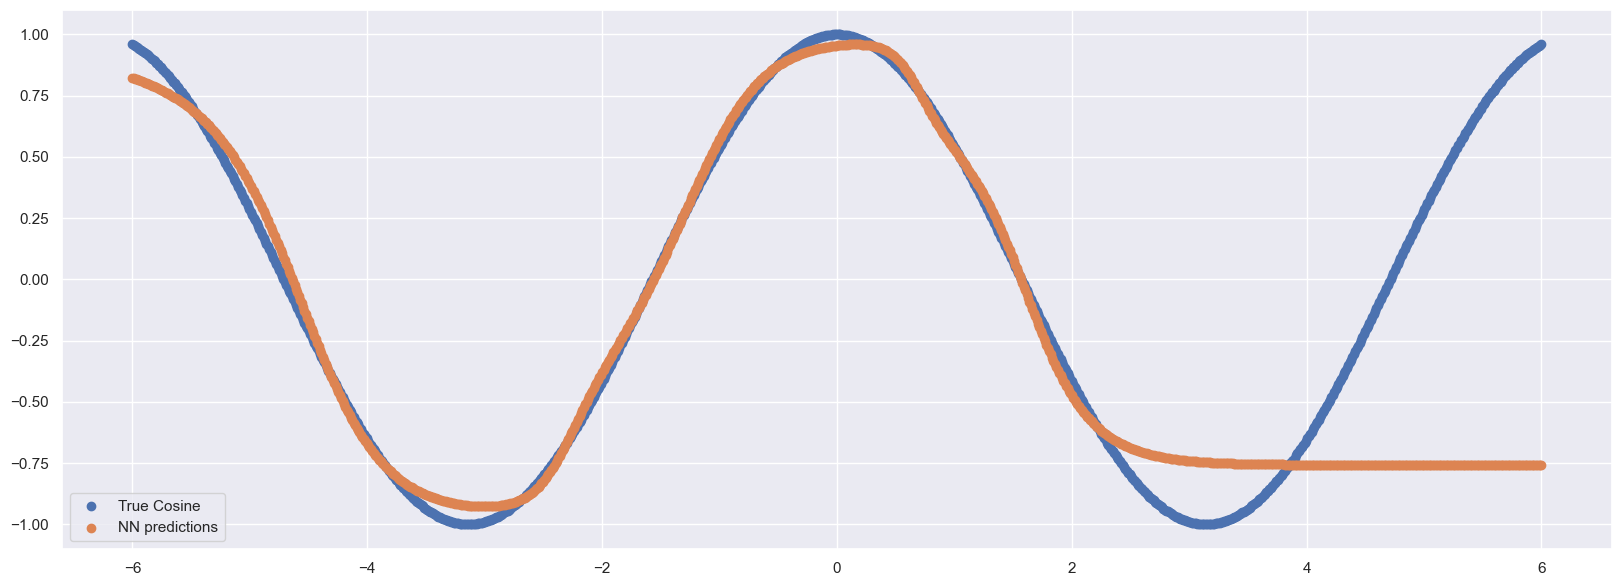

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

X_test = torch.linspace(-6, 6, 1000).to(device)
Y_test = torch.cos(X_test)

nn_prediction = NN(X_test.view(-1, 1))
nn_prediction = nn_prediction.cpu().detach().numpy()

plt.figure(figsize=(20,7))
plt.scatter(x=X_test.cpu(), y=Y_test.cpu(), label='True Cosine');
plt.scatter(x=X_test.cpu(), y=nn_prediction, label='NN predictions');
plt.legend()

OK